In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,mean_squared_error
from sklearn.linear_model import LogisticRegressionCV
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [8]:
training = pd.read_csv('Training Data.csv')
training.head(5)

,Id,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [9]:
test = pd.read_csv('Test Data.csv')
test.head(5)

,ID,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10,0
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14,1
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12,0
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11,0


# Data Cleaning

In [10]:
enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
col = ['Married_Single','House_Ownership','Car_Ownership','Profession','CITY','STATE']
training[col] = training[col].apply(lambda x: le.fit_transform(x)) 
array_hot_encoded = enc.fit_transform(training[col])
training = training.rename(columns={'Id': 'ID'})
training.head(5) 

,ID,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,1,2,0,33,251,13,3,13,0
1,2,7574516,40,10,1,2,0,43,227,14,9,13,0
2,3,3991815,66,4,0,2,0,47,8,12,4,10,0
3,4,6256451,41,2,1,2,1,43,54,17,2,12,1
4,5,5768871,47,11,1,2,0,11,296,22,3,14,1


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
col = ['Married_Single','House_Ownership','Car_Ownership','Profession','CITY','STATE']
test[col] = test[col].apply(lambda x: le.fit_transform(x)) 
array_hot_encoded = enc.fit_transform(test[col])

test.head(5) 

,ID,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,7393090,59,19,1,2,0,26,181,28,4,13,0
1,2,1215004,25,5,1,2,0,24,131,14,5,10,0
2,3,8901342,50,12,1,2,0,30,290,14,9,14,1
3,4,1944421,49,9,0,2,1,1,171,14,3,12,0
4,5,13429,25,18,1,2,1,12,39,28,13,11,0


# Modeling

## Logistic Regression, tuning hyperparameters

### method 1

In [31]:
df = pd.concat([training, test])
X = df.drop(['Risk_Flag', 'ID'], axis=1).to_numpy()
y = df['Risk_Flag'].to_numpy()

#X_train, y_train = training.iloc[:, 1:12], training.iloc[:, 12]
#X_test, y_test = test.iloc[:, 1:12], test.iloc[:, 12]

In [54]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
log_sum = []
for C in C_values:
    mse = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train, val in kf.split(X):
        X_train, X_test = X[train.tolist()], X[val.tolist()]
        y_train, y_test = y[train.tolist()], y[val.tolist()]
        
        pipe = Pipeline([('s', SMOTE(random_state=42)), ('lr', LogisticRegression(C=C, solver='liblinear'))])
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        
        mse.append(mean_squared_error(y_test, y_pred))
        
    log_sum.append([C, np.mean(mse)])

In [55]:
table = pd.DataFrame(log_sum, columns=['C', 'mse_log']).set_index(['C'])
best_c = table['mse_log'].idxmin()
print('Best C value:', best_c)
print('Mean Squeared Error:', table['mse_log'].min())

Best C value: 0.1
Mean Squeared Error: 0.4194357142857143


In [57]:
from sklearn.model_selection import train_test_split

# Split your dataset into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Refit the model with the best C value on the entire training dataset
pipe_best = Pipeline([('s', SMOTE(random_state=42)), ('lr', LogisticRegression(C=best_c, solver='liblinear'))])
pipe_best.fit(X_train, y_train)

# Evaluate the model on the held-out test set
y_pred = pipe_best.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.5822678571428571
Precision: 0.1298917194590466
Recall: 0.417895345475571
F1-score: 0.1981833761782348
ROC-AUC: 0.5116655733938305


### method 2

In [ ]:
pipe = Pipeline([('smote', SMOTE(random_state=42)), ('lr', LogisticRegression())])

# Define hyperparameters to tune
param_grid = {'lr__penalty': ['l1', 'l2'],
              'lr__C': [0.001, 0.01, 0.1, 1, 10],
              'lr__solver': ['liblinear', 'saga']}

# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

In [ ]:
# Get best hyperparameters and score
print("Best hyperparameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)

# Make predictions on the training set
y_pred = best_pipe.predict(X_test)

# Evaluate performance using evaluation metrics and confusion matrix
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_mat)

Precision: 0.1328610248447205
Recall: 0.5541067969585707
F1 score: 0.2143308451452375
AUC-ROC: 0.522195221787939
Confusion matrix:
[[120321 125090]
 [ 15423  19166]]


## XGBoost


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a pipeline with SMOTE and XGBoost
pipe = Pipeline([('smote', SMOTE(random_state=42)), ('xgb', XGBClassifier(objective='binary:logistic', use_label_encoder=False))])

# Define hyperparameters to tune
param_grid = {'xgb__learning_rate': [0.01, 0.1, 1],
              'xgb__max_depth': [3, 5, 7],
              'xgb__n_estimators': [50, 100, 200]}

# Perform grid search with 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='f1')
grid.fit(X_train, y_train)

# Get best hyperparameters and score
print("Best hyperparameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

# Train the model on the entire dataset using the best hyperparameters
best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)

# Make predictions on the training set
y_pred = best_pipe.predict(X_test)

# Evaluate performance using evaluation metrics and confusion matrix
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_mat)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters:  {'xgb__learning_rate': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Best score:  0.5755211217872404
Precision: 0.533014459288581
Recall: 0.840874266385267
F1 score: 0.6524518820943066
AUC-ROC: 0.8685201449565723
Confusion matrix:
[[219929  25482]
 [  5504  29085]]


AUC-ROC: 0.9282374927468799


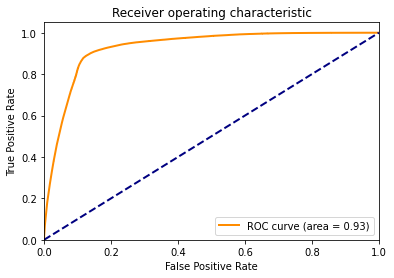

In [ ]:
y_prob = best_pipe.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC-ROC score
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()